# Test du Chi-2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import vectorize
from math import gamma
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18, 10)


@vectorize
def G(x):
    return gamma(x)


def mk_f_khi2(m):
    @vectorize
    def f_khi2(x):
        return (
            x**((m - 1) / 2 - 1) * np.exp(-x / 2)
        ) / (
            G((m - 1) / 2) * 2**((m - 1) / 2)
        )

    return f_khi2

# Applications

## La pièce est-elle truquée ?

### Donner la loi de $Z$ a priori.

$Z \sim Bernoulli(0.5)$

### Vérifier par simulation et à l’aide d’un histogramme que lorsque $Z$ suit cette loi apriori, la variable $D_n$ associée suit approximativement, pour $n$ grand, une loi du Khi-deux.

In [2]:
def D(n, gen_Z, P, N):
    Z = gen_Z(n, N)
    support = np.unique(Z)
    x = np.array([np.count_nonzero(Z == k, axis=0) / n for k in support])
    prob = np.repeat(np.expand_dims(P(support), 1), N, axis=1)
    return n * np.sum((x - prob)**2 / prob, axis=0)

In [3]:
def test_D(P, gen_Z, custom_f=None, custom_x=None):
    m = len(np.unique(gen_Z(10_000, 10_000)))
    f = custom_f or mk_f_khi2(m)
    x = np.linspace(0, 12) if custom_x is None else custom_x

    plt.hist(D(10_000, gen_Z, P, 5000), density=True, bins=100)
    plt.plot(x, f(x))
    plt.show()

In [4]:
@vectorize
def P(res):
    return 0.5


def gen_Z(n, N):
    return np.random.random((n, N)) < 0.5

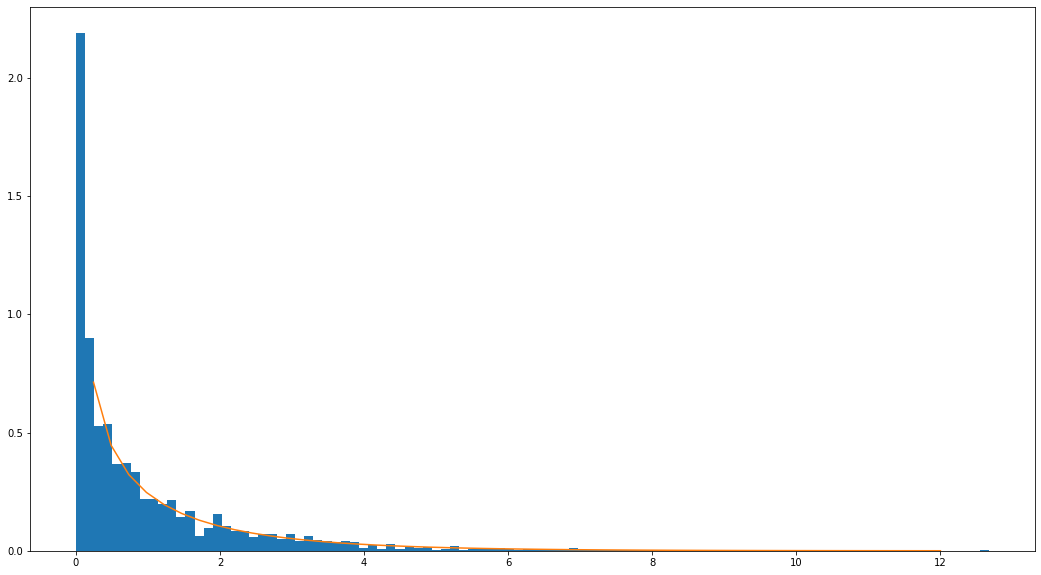

In [5]:
test_D(P, gen_Z)

In [6]:
def new_Z(n, N):
    return np.random.random((n, N)) < 0.65


d = D(100, new_Z, P, 10_000).mean()
val_tableau = 3.28
print(f"{d=}")

if d > val_tableau:
    print("Rejet de l'hypothese !")
else:
    print("Hypothese ok")

d=9.822972
Rejet de l'hypothese !


## Le dé est-il truqué ?

### Donner la loi de $Z$ a priori.

In [7]:
def gen_Z(n, N):
    """
    Equiprobable : {1,2,3,4,5,6}
    """
    return np.random.randint(1, 7, (n, N))

### Vérifier par simulation et à l’aide d’un histogramme que lorsque $Z$ suit cette loi apriori, la variable $D_n$ associée suit approximativement, pour $n$ grand, une loi du Khi-deux.

In [8]:
@vectorize
def P(res):
    return 1 / 6

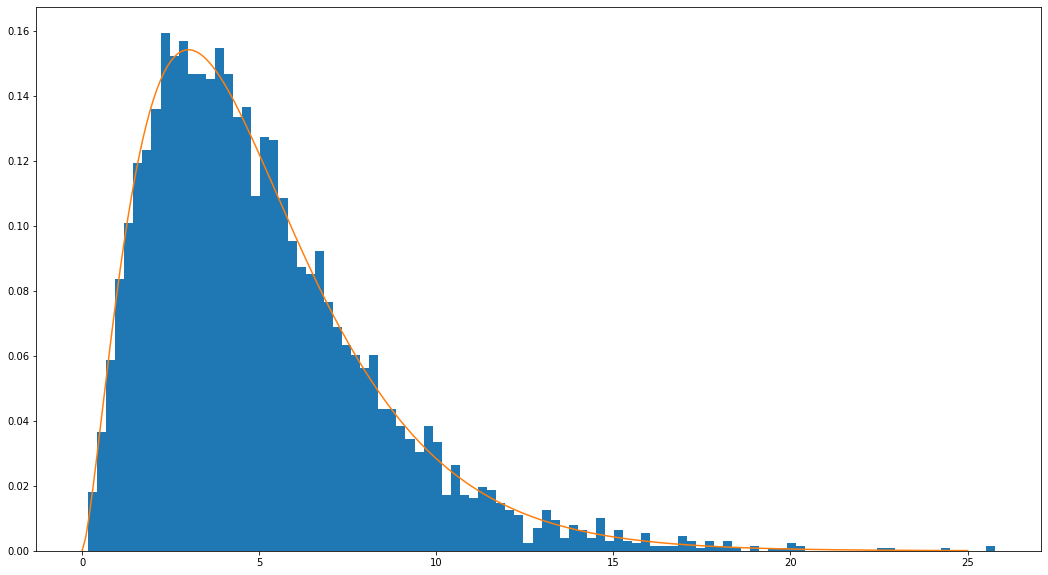

In [9]:
test_D(P, gen_Z, custom_x=np.linspace(0, 25, 250))

In [10]:
def new_Z(n, N):
    p = np.array([108, 95, 98, 89, 106, 104]) / 600
    return np.random.choice([1, 2, 3, 4, 5, 6], size=(n, N), p=p)


d = D(600, new_Z, P, 10_000).mean()
val_tableau = 11.07
print(f"{d=}")

if d > val_tableau:
    print("Rejet de l'hypothese !")
else:
    print("Hypothese ok")

d=7.676038
Hypothese ok


## Loi de Poisson ou non ?

### De quelle façon naturelle peut-on estimer le paramètre $\lambda$ ?

On vas faire une régression pour déterminer le paramètre $\lambda$ : on donne a `scipy.optimize.curve_fit` une fonction a optimizer suivant des parametres, ici `f(x, l)`.

On obtient ensuite le paramètre optimal trouvé pour $\lambda$ et on calcule le $R^2$ pour connaitre la qualité de la régression.

In [11]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

X ~ E(l=1.082)
R2 = 0.965


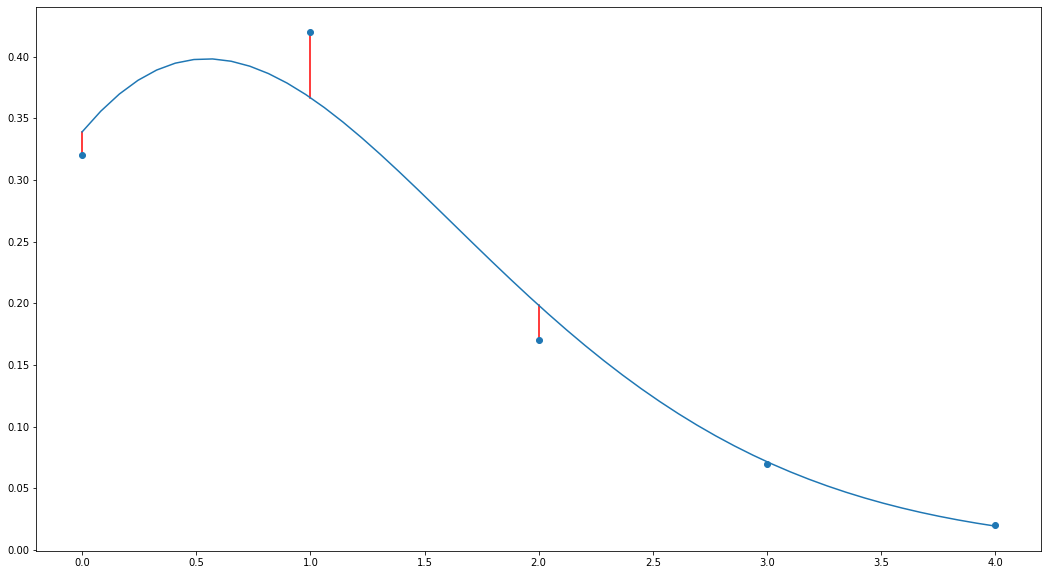

In [12]:
x = np.arange(5)
y = np.array([32, 42, 17, 7, 2]) / 100


def f(x, l):
    return np.exp(-l) * l**x / G(x + 1)


param, _ = curve_fit(f, x, y, maxfev=5000)


def F(x):
    return f(x, *param)


print(f"X ~ E(l={param[0]:.3f})")
print(f"R2 = {r2_score(y, F(x)):.3f}")


def gen_Z(n, N):
    return np.random.poisson(lam=param[0], size=(n, N))


_x = np.linspace(0, 4)
for px, py in zip(x, y):
    plt.plot([px, px], [py, F(px)], "r-", zorder=-1)
plt.scatter(x, y)
plt.plot(_x, F(_x))
plt.show()

### Vérifier par simulation et à l’aide d’un histogramme que lorsque $Z$ suit cette loi apriori, la variable $D_n$ associée suit approximativement, pour $n$ grand, une loi du Khi-deux.

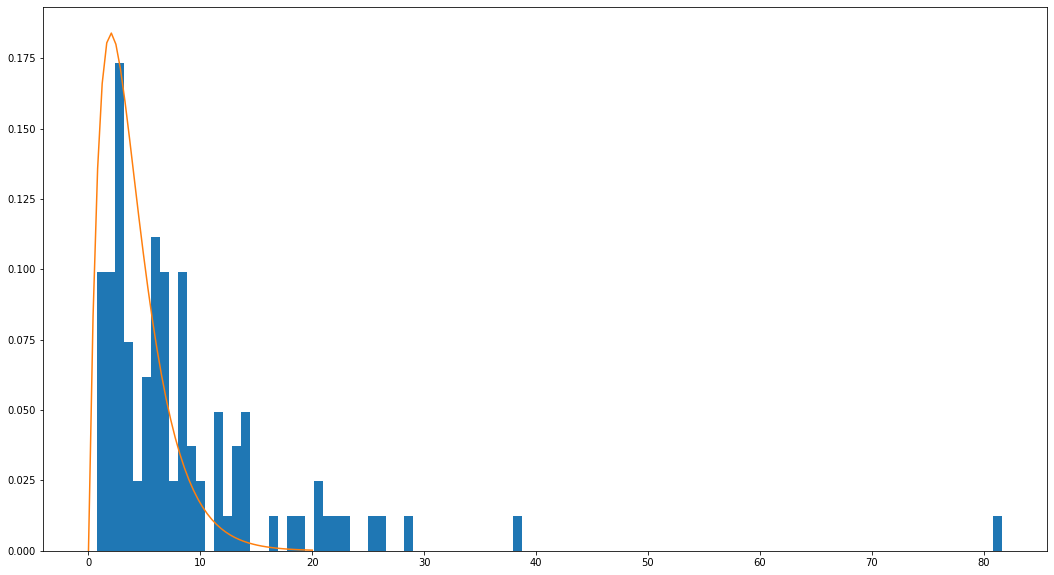

d=21.11586391918792
Rejet de l'hypothese !


In [13]:
@vectorize
def P(x):
    return np.exp(-1) / G(x + 1)


f = mk_f_khi2(5)
x = np.linspace(0, 20)

plt.hist(D(100, gen_Z, P, 100), density=True, bins=100)
plt.plot(x, f(x))
plt.show()

d = D(100, gen_Z, P, 10_000).mean()
val_tableau = 9.49
print(f"{d=}")

if d > val_tableau:
    print("Rejet de l'hypothese !")
else:
    print("Hypothese ok")